## Análise feita por Felipe Carvalho e Daniela Zaramello utilizando a API do [SISU](https://sisusimulator.com.br)


### Verificamos as notas e cotas do curso de medicina de algumas faculdade federais

# Importando as libs

In [96]:
import pandas as pd
import requests as rt
import re
import json
from collections import OrderedDict
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# Métodos para buscar o id e curso na API


In [97]:
def search_by_curso(curso):
  file = rt.get("https://sisusimulator.com.br/api/searchcursosslug.php?slugCurso="+curso)
  return(file.json())
  

def search_by_id(id):
  file = rt.get("https://sisusimulator.com.br/api/curso.php?parameter=id&id="+id)
  return(file.json())



# Procurando pelo curso de medicina

In [98]:
data = search_by_curso('medicina')

list_course = [search_by_id(data[i]['id']) for i in range(len(data))]



## Perguntas durante a análise:
1. Que tipo de variação ocorre nas minhas variáveis?

2. Que tipo de covariação ocorre entre minhas variáveis?


Para responder as pergurtas é necessário ter uma base , por exemplo, o que são variáveis qualitativas e quantitativas:


1. Variáveis Quantitativas: são as características que podem ser medidas em uma escala quantitativa, ou seja, apresentam valores numéricos que fazem sentido. Podem ser contínuas ou discretas.

- Variáveis discretas: características mensuráveis que podem assumir apenas um número finito ou infinito contável de valores e, assim, somente fazem sentido valores inteiros. Geralmente são o resultado de contagens. Exemplos: número de filhos, número de bactérias por litro de leite, número de cigarros fumados por dia.

- Variáveis contínuas, características mensuráveis que assumem valores em uma escala contínua (na reta real), para as quais valores fracionais fazem sentido. Usualmente devem ser medidas através de algum instrumento. Exemplos: peso (balança), altura (régua), tempo (relógio), pressão arterial, idade.

2. Variáveis Qualitativas (ou categóricas): são as características que não possuem valores quantitativos, mas, ao contrário, são definidas por várias categorias, ou seja, representam uma classificação dos indivíduos. Podem ser nominais ou ordinais.
        
- Variáveis nominais: não existe ordenação dentre as categorias. Exemplos: sexo, cor dos olhos, fumante/não fumante, doente/sadio.
        
- Variáveis ordinais: existe uma ordenação entre as categorias. Exemplos: escolaridade (1o, 2o, 3o graus), estágio da doença (inicial, intermediário, terminal), mês de observação (janeiro, fevereiro,..., dezembro).


 
Obs.: No caso desse conjunto de dados, nota é uma variável contínua. Segundo Hadley, uma dado tabular (tidy), tem sua propria célula, cada variável tem sua propria coluna e cada oberservação tem sua propria linha.

1.1 O que é viariação?
Variação é a tendência dos valores de uma variável mudar de medida para medida. No caso, a nota de cada cota, muda de ano para ano, pois aumenta ou dimunui o número de pessoas realizando a prova e a média aumento ou dimunui de acordo com  a nota dos participantes

1.2 O que é covariação?
Covariação descreve o comportamento entre variáveis, é a tendencia para valores de duas ou mais variáveis variarem juntas de uma forma relacionada.


# Criando o dataframe a partir da API

In [99]:
lista_cmp = [[i[0]['id'],
                 i[0]['notasDeCorte'][j]['nota'], 
                 i[0]['notasDeCorte'][j]['descricao'],
                 i[0]['notasDeCorte'][j]['ano'],
                 i[0]['slugCampus'],
                 i[0]['slugUni']] for i in list_course for j in range(len(i[0]['notasDeCorte']))]

teste = pd.DataFrame.from_records(lista_cmp, columns=['id','nota','cota','ano', 'campus', 'faculdade'])


## Limpando o dado

In [100]:
# Primeira vamos visualizar o dado
teste.head(10)

,id,nota,cota,ano,campus,faculdade
0,9,728.54,"Candidatos autodeclarados pretos, pardos ou in...",2016.1,campus-universitario-de-sinop,ufmt
1,9,777.78,Ampla Concorrência,2016.1,campus-universitario-de-sinop,ufmt
2,9,732.44,"Candidatos que, independentemente da renda (ar...",2016.1,campus-universitario-de-sinop,ufmt
3,9,730.24,Candidatos com renda familiar bruta per capita...,2016.1,campus-universitario-de-sinop,ufmt
4,9,724.40,"Candidatos autodeclarados pretos, pardos ou in...",2016.1,campus-universitario-de-sinop,ufmt
5,9,782.62,Ampla concorrência,2017.1,campus-universitario-de-sinop,ufmt
6,9,729.58,"Candidatos autodeclarados pretos, pardos ou in...",2017.1,campus-universitario-de-sinop,ufmt
7,9,735.52,"Candidatos autodeclarados pretos, pardos ou in...",2017.1,campus-universitario-de-sinop,ufmt
8,9,741.28,Candidatos com renda familiar bruta per capita...,2017.1,campus-universitario-de-sinop,ufmt
9,9,760.88,"Candidatos que, independentemente da renda (ar...",2017.1,campus-universitario-de-sinop,ufmt


## A descrição da cota está muito grande, desta maneira, pode poluir nossa legenda e dificultar na hora da visualização, sendo assim, vamos mapear as cotas que mais aparece

In [101]:
teste['cota'].value_counts()

Candidatos que, independentemente da renda (art. 14, II, Portaria Normativa nº 18/2012), tenham cursado integralmente o ensino médio em escolas públicas (Lei nº 12.711/2012).                                                                                                                                                                                                                                                                                         159
Candidatos com renda familiar bruta per capita igual ou inferior a 1,5 salário mínimo que tenham cursado integralmente o ensino médio em escolas públicas (Lei nº 12.711/2012).                                                                                                                                                                                                                                                                                        159
Candidatos autodeclarados pretos, pardos ou indígenas, com renda familiar bruta pe

####Agora que sabemos quais cotas que são mais comuns, vamos limpar nosso dado

In [102]:
COTA1 = "Candidatos com renda familiar bruta per capita igual ou inferior a 1,5 salário mínimo que tenham cursado integralmente o ensino médio em escolas públicas (Lei nº 12.711/2012)."
COTA2 = "Candidatos que, independentemente da renda (art. 14, II, Portaria Normativa nº 18/2012), tenham cursado integralmente o ensino médio em escolas públicas (Lei nº 12.711/2012)." 
COTA3 = "Candidatos autodeclarados pretos, pardos ou indígenas que, independentemente da renda (art. 14, II, Portaria Normativa nº 18/2012), tenham cursado integralmente o ensino médio em escolas públicas (Lei nº 12.711/2012)."                                                                                                                                                                                                                                                                                        
COTA4 = "Candidatos autodeclarados pretos, pardos ou indígenas, com renda familiar bruta per capita igual ou inferior a 1,5 salário mínimo e que tenham cursado integralmente o ensino médio em escolas públicas (Lei nº 12.711/2012)."
AP1 = "Ampla Concorrência"
AP2 = "Ampla concorrência"

def muda_cota(cota):
    if cota == COTA1:
        return("COTA1")    
    elif cota == COTA2:
        return("COTA2")
    elif cota == COTA3:
        return("COTA3")
    elif cota == COTA4:
        return("COTA4")
    elif cota ==  AP1 or cota == AP2:
        return("AP")        
    else:
        return("OUTROS")

# Solução usando apply no lugar do for
teste['cota'] = teste['cota'].apply(muda_cota)

# Mudando o tipo de coluna nota para númerico, assim podemos trabalhar com ela no eixo y
teste['nota'] = teste['nota'].apply(pd.to_numeric)

### Vamos visualizar o nosso dado depois da limpeza

In [103]:
teste.head(10)

,id,nota,cota,ano,campus,faculdade
0,9,728.54,COTA3,2016.1,campus-universitario-de-sinop,ufmt
1,9,777.78,AP,2016.1,campus-universitario-de-sinop,ufmt
2,9,732.44,COTA2,2016.1,campus-universitario-de-sinop,ufmt
3,9,730.24,COTA1,2016.1,campus-universitario-de-sinop,ufmt
4,9,724.40,COTA4,2016.1,campus-universitario-de-sinop,ufmt
5,9,782.62,AP,2017.1,campus-universitario-de-sinop,ufmt
6,9,729.58,COTA4,2017.1,campus-universitario-de-sinop,ufmt
7,9,735.52,COTA3,2017.1,campus-universitario-de-sinop,ufmt
8,9,741.28,COTA1,2017.1,campus-universitario-de-sinop,ufmt
9,9,760.88,COTA2,2017.1,campus-universitario-de-sinop,ufmt


Certo, vamos para as visualizações!

# Visualizações

###Quantidade total de cotas




/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


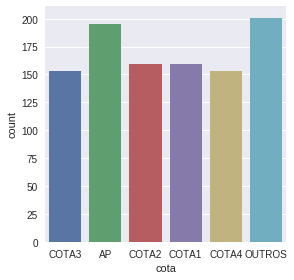

In [104]:
plt.figure(figsize=(8, 8))
sns.factorplot('cota', data=teste, kind="count")

No caso, podemos observar que as cotas 'OUTROS' e a 'AP' são as que mais aparecem no data.frame

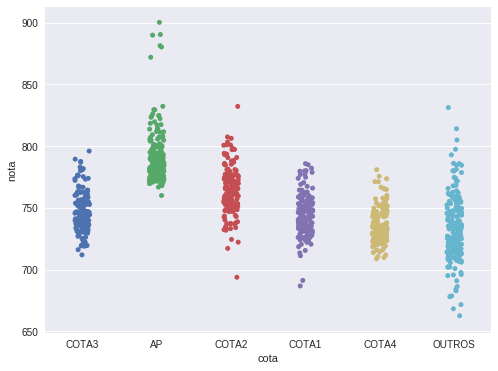

In [105]:
plt.figure(figsize=(8, 6))
g = sns.stripplot(x='cota', y='nota', data=teste, jitter=True)

Distrubuição de notas por cotas em todos os semestres

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


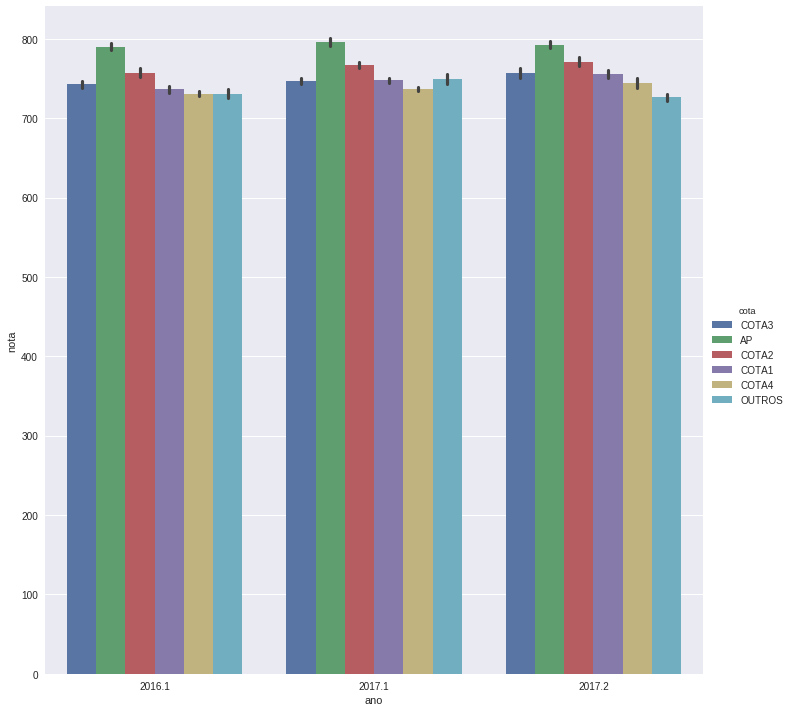

In [106]:
g = sns.factorplot(x='ano', y='nota', data=teste, hue='cota' ,estimator=np.mean, kind="bar", size=10)


Nesse plot, podemos obervar a média das notas de corte nos semestres, cujo a maior nota de corte para a cota 'AP' foi no primeiro semestre de 2017.
Representação:

2016.1 = Primeiro semestre de 2016

2017.1 = Primeiro semestre de 2017

2017.2 = Segundo semestre de 2017

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:637: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data[hue_mask])
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:932: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data[hue_mask])


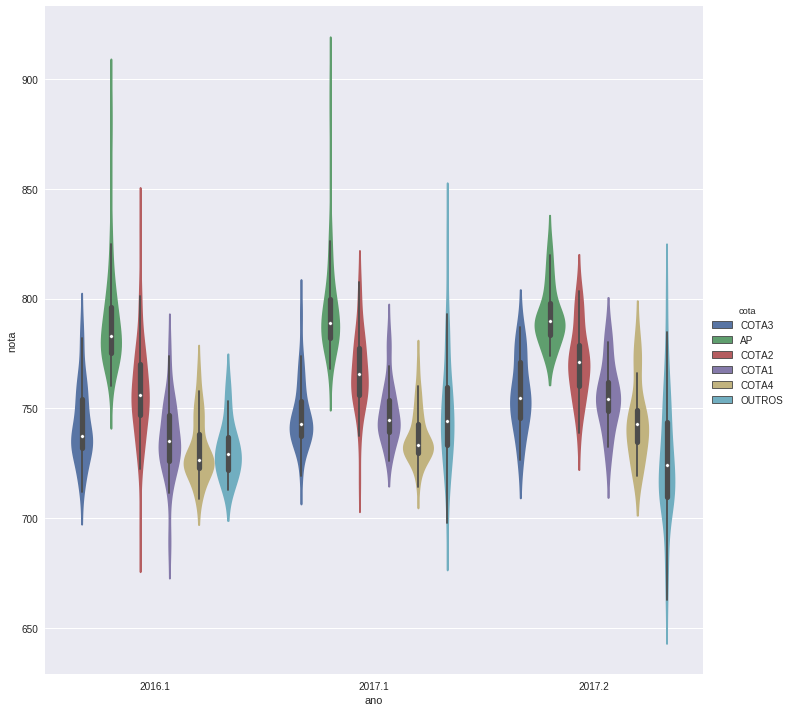

In [107]:
g = sns.factorplot(x='ano', y='nota', data=teste, hue='cota' ,estimator=np.mean, kind="violin", size=10, dodge=True)

Distribuições baseadas em um modelo não-paramétrico

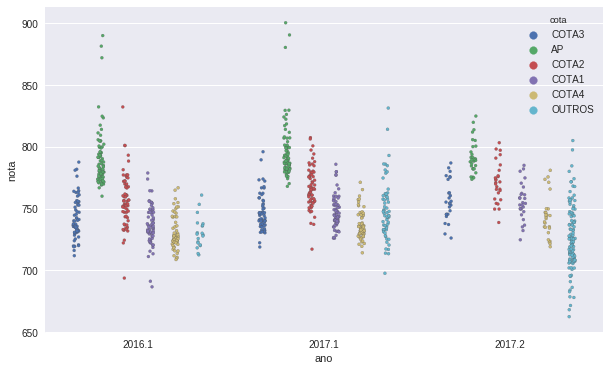

In [108]:
plt.figure(figsize=(10, 6))
g = sns.stripplot(x='ano', y='nota', hue='cota', split = True, data=teste, jitter=True, size=3, linewidth=0.2)


Distrubuição de notas por cotas em cada  semestre de todas universidades


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


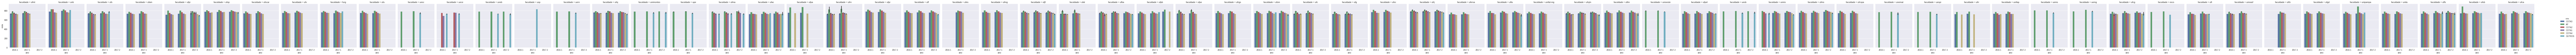

In [109]:
plt.figure(figsize=(12, 6))
g = sns.factorplot(x="ano", y="nota",
hue="cota", col="faculdade", data=teste, kind="bar", size=4, aspect=.7)

Visualização da média por cotas em cada semestre das universidades. Podemos notar que, algumas universidade não abrem chamadas no SISU  no segundo semestre, isso ocorre com as univerdade mais conhecidas, como UFMG, UFPR e assim por diante.

# (Opcional) Código para gerar CSV  utilizando google colab

In [5]:
from google.colab import files

teste.to_csv('./dataset_med.csv', sep='\t', encoding='utf-8' )
files.download('dataset_med.csv')

